# Task 3: real pendulum

Sam Greydanus

In [1]:
import torch, time, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-real'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, hamiltonian_fn, dynamics_fn
from nn_models import MLP
from hnn import HNN
from utils import L2_loss

## Set some notebook constants

In [2]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 30 # 100 for pend-sim, 30 for pend-real
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'field_type': 'solenoidal',
         'total_steps': 2000,
         'print_every': 200,
         'name': 'real',
         'gridsize': 10,
         'seed': 0,
         'save_dir': '{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Inspect the dataset

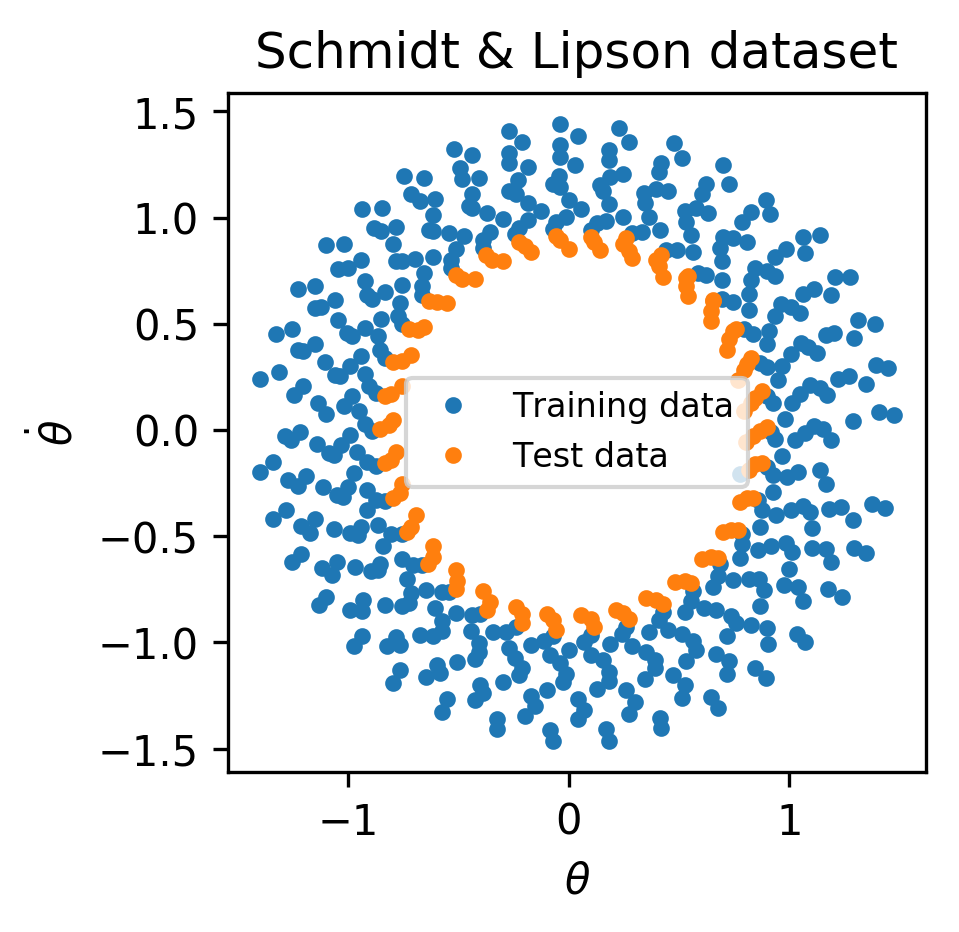

In [3]:
args = ObjectView(get_args())
np.random.seed(args.seed)
data = get_dataset('pend-real', args.save_dir)

plt.figure(figsize=[3,3], dpi=DPI)
plt.plot(data['x'][:,0], data['x'][:,1], '.', label='Training data')
plt.plot(data['test_x'][:,0], data['test_x'][:,1], '.', label='Test data')
plt.title('Schmidt & Lipson dataset')
plt.xlabel('$\\theta$') ; plt.ylabel('$\dot \\theta$')
plt.legend(fontsize=8)
plt.show()

## Construct models

In [29]:
def get_model(args, baseline):
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=baseline)
    
    model_name = 'baseline' if baseline else 'hnn'
    path = "{}/real{}-{}.tar".format(args.save_dir, RK4, model_name)
    model.load_state_dict(torch.load(path))
    return model

base_model = get_model(args, baseline=True)
hnn_model = get_model(args, baseline=False)

## Visualize HNN scalar field

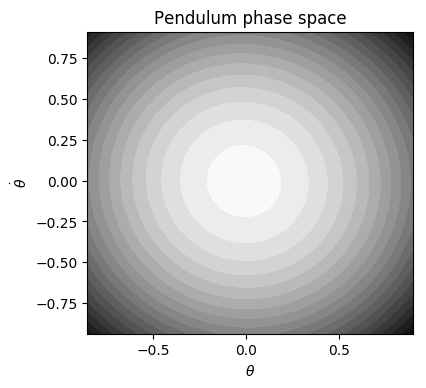

In [30]:
def get_range(data):
    xmin, xmax = data['test_x'][:,0].min(), data['test_x'][:,0].max()
    dxmin, dxmax = data['test_x'][:,1].min(), data['test_x'][:,1].max()
    return (xmin, xmax, dxmin, dxmax)

def get_mesh_inputs(data, gridsize=10):
    xmin, xmax, dxmin, dxmax = get_range(data)
    
    mesh_x, mesh_dx = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(dxmin, dxmax, gridsize))
    np_mesh_inputs = np.stack([mesh_x.flatten(), mesh_dx.flatten()]).T
    mesh_inputs = torch.tensor( np_mesh_inputs, requires_grad=True, dtype=torch.float32)
    return mesh_inputs

# get scalar fields
gridsize = 30
mesh_inputs = get_mesh_inputs(data, gridsize)
X = mesh_inputs.reshape(gridsize, gridsize, 2)[...,0].detach().data.numpy()
dX = mesh_inputs.reshape(gridsize, gridsize, 2)[...,1].detach().data.numpy()

F1, F2 = hnn_model.forward(mesh_inputs)
np_F2 = F2.data.numpy().reshape(gridsize,gridsize)

# plot
fig = plt.figure(figsize=(4.2, 4), facecolor='white', dpi=100)
ax = fig.add_subplot(1, 1, 1, frameon=True)
plt.contourf(X, dX, np_F2, cmap='gray_r', levels=20)
ax.set_xlabel("$\\theta$") ; ax.set_ylabel("$\dot \\theta$")
plt.title("Pendulum phase space")

plt.show()

## Integrate along data

In [31]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [32]:
# integrate along those fields starting from point (1,0)
t_span = [0,20]
y0 = np.asarray([0.75, 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
base_ivp = integrate_model(base_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)

## Visualize vector fields

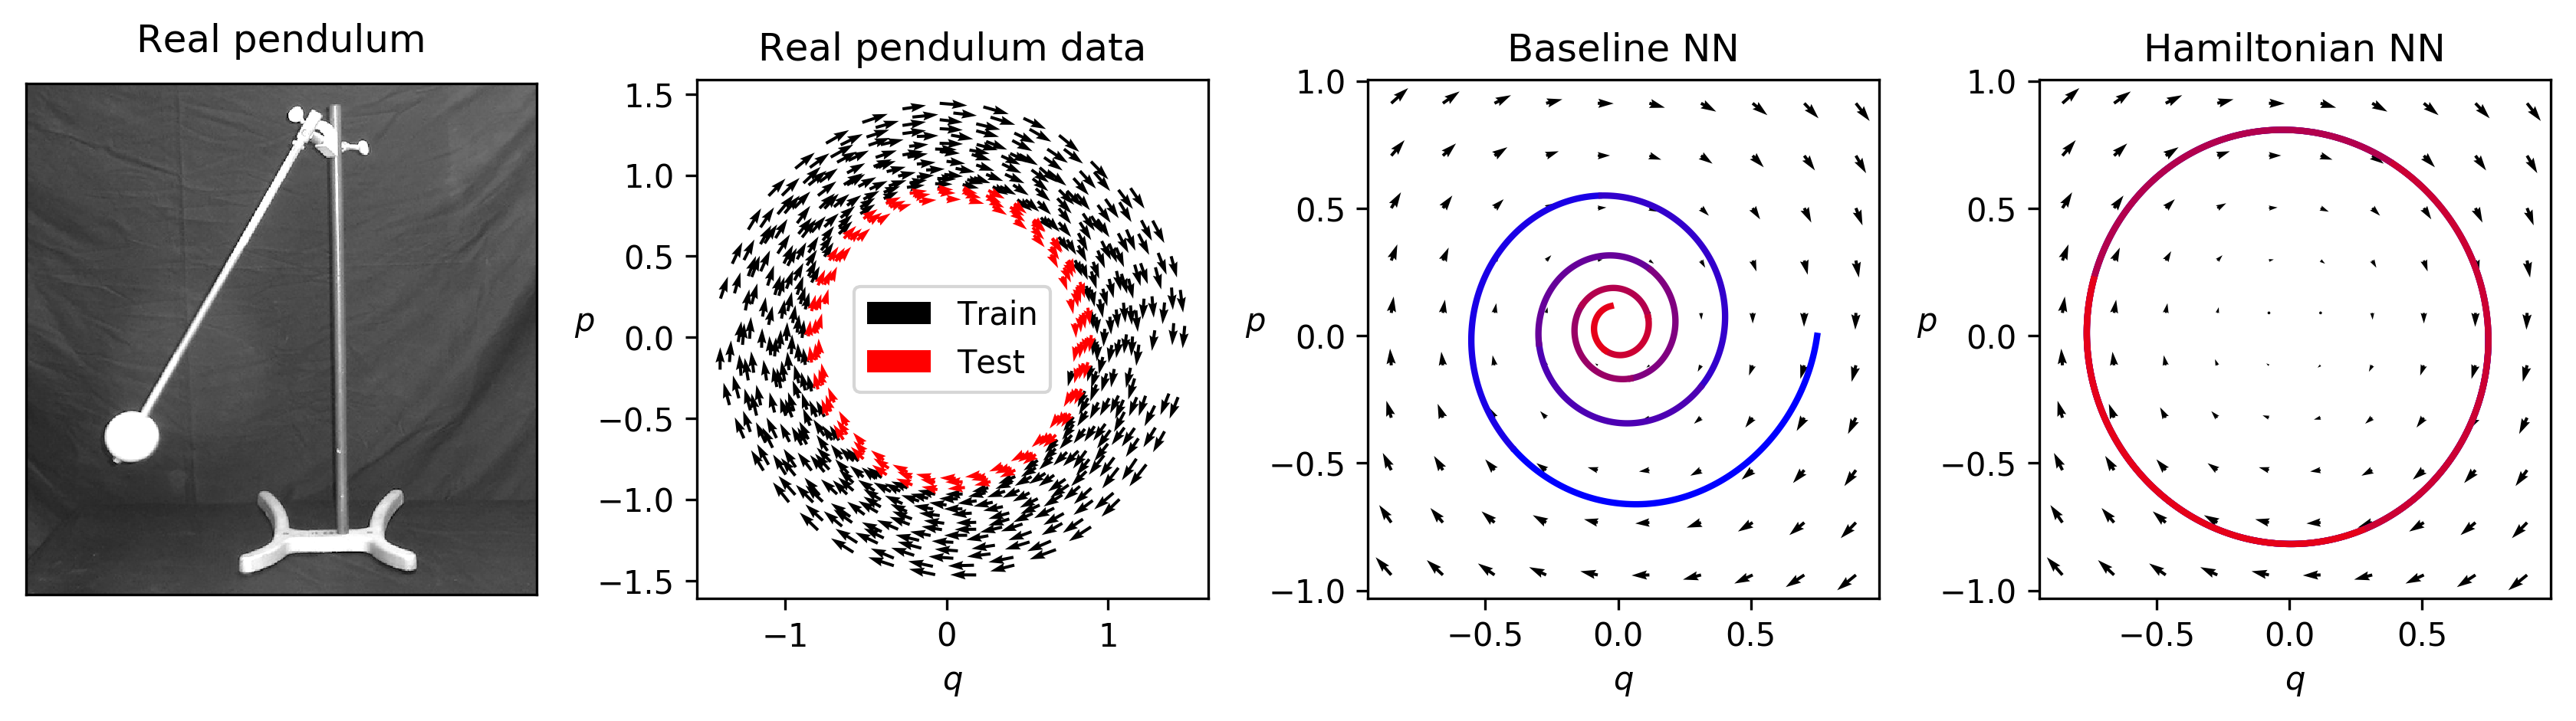

In [33]:
###### GET VECTOR FIELDS ######
mesh_inputs = get_mesh_inputs(data, gridsize=10)
input_x = mesh_inputs.detach().numpy()
base_dx = base_model.time_derivative(mesh_inputs).detach().numpy()
hnn_dx = base_model.time_derivative(mesh_inputs).detach().numpy()

###### PLOT ######
fig = plt.figure(figsize=(11.3, 3.2), facecolor='white', dpi=DPI)

# plot physical system
fig.add_subplot(1, 4, 1, frameon=True) 
plt.xticks([]) ;  plt.yticks([])
schema = mpimg.imread(EXPERIMENT_DIR + '/pendulum.png')
plt.imshow(schema)
plt.title("Real pendulum", pad=10)

# plot dataset
ax = fig.add_subplot(1, 4, 2, frameon=True)
ax.quiver(data['x'][:,0], data['x'][:,1], data['dx'][:,0], data['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, label='Train')
ax.quiver(data['test_x'][:,0], data['test_x'][:,1], data['test_dx'][:,0], data['test_dx'][:,1],
        cmap='gray_r', color='red', scale=ARROW_SCALE, width=ARROW_WIDTH, label='Test')

ax.set_xlabel("$q$")
ax.set_ylabel("$p$", rotation=0)
ax.set_title("Real pendulum data")
plt.legend()

# plot baseline
ax = fig.add_subplot(1, 4, 3, frameon=True)
ax.quiver(input_x[:,0], input_x[:,1], base_dx[:,0], base_dx[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH)  

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    ax.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
ax.set_xlabel("$q$")
ax.set_ylabel("$p$", rotation=0)
ax.set_title("Baseline NN")

# plot HNN
ax = fig.add_subplot(1, 4, 4, frameon=True)
ax.quiver(input_x[:,0], input_x[:,1], hnn_dx[:,0], hnn_dx[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH)

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    ax.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
ax.set_xlabel("$q$")
ax.set_ylabel("$p$", rotation=0)
ax.set_title("Hamiltonian NN")

plt.tight_layout() ; plt.show()
fig.savefig('{}/real{}.{}'.format(args.fig_dir, RK4, FORMAT))

## Quantitative analysis
* Choose trajectories from the test set
* Measure vector field loss at each point
* Integrate along trajectory and measure mean loss between points

In [34]:
# get trajectory of true test data
t_eval = np.squeeze( data['test_t'] - data['test_t'].min() )
t_span = [t_eval.min(), t_eval.max()]
x0 = data['test_x'][0]
true_x = data['test_x']

# integrate along baseline vector field
base_path = integrate_model(base_model, t_span, x0, t_eval=t_eval)
base_x = base_path['y'].T

# integrate along HNN vector field
hnn_path = integrate_model(hnn_model, t_span, x0, t_eval=t_eval)
hnn_x = hnn_path['y'].T

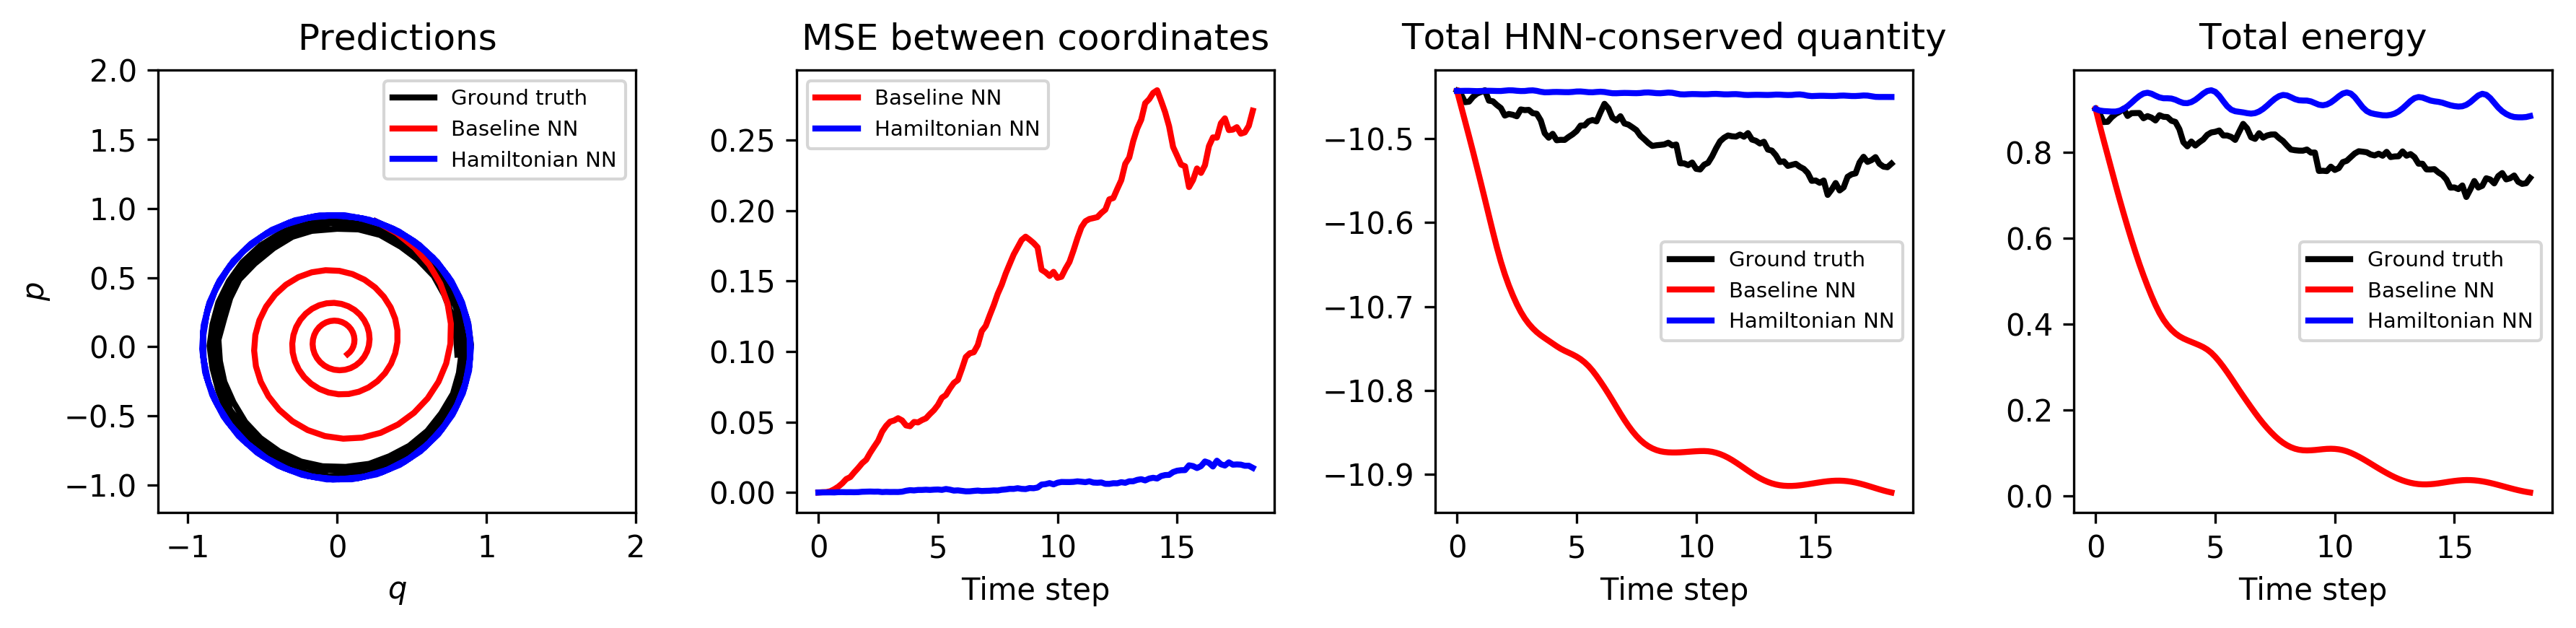

In [35]:
# x0 = np.asarray([1, 0])

# # integration
# t_span=[0,20]
# t_eval = np.linspace(t_span[0], t_span[1], 2000)

# plotting
tpad = 7

fig = plt.figure(figsize=[12,3], dpi=DPI)
plt.subplot(1,4,1)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
plt.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=2)
plt.xlim(-1.2,2) ; plt.ylim(-1.2,2)
plt.legend(fontsize=7)

plt.subplot(1,4,2)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,3)
plt.title("Total HNN-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = hnn_model(torch.Tensor(true_x))[1].detach().numpy().squeeze()
base_hq = hnn_model(torch.Tensor(base_x))[1].detach().numpy().squeeze()
hnn_hq = hnn_model(torch.Tensor(hnn_x))[1].detach().numpy().squeeze()
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,4)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([hamiltonian_fn(c) for c in true_x])
base_e = np.stack([hamiltonian_fn(c) for c in base_x])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_x])
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()
fig.savefig('{}/real-integration{}.{}'.format(args.fig_dir, RK4, FORMAT))

In [36]:
# # plotting
# fig = plt.figure(figsize=[9,3], dpi=DPI)
# plt.subplot(1,3,1)
# plt.title("Predictions") ; plt.xlabel('$q$') ; plt.ylabel('$p$')
# plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
# plt.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
# plt.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=2)
# plt.xlim(-1,2) ; plt.ylim(-1,2)
# plt.legend(fontsize=7, loc='upper right')

# plt.subplot(1,3,2)
# plt.title("MSE between coordinates") ; plt.xlabel('Time step')
# plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
# plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
# plt.legend(fontsize=7)

# plt.subplot(1,3,3)
# plt.title("Total energy")
# plt.xlabel('Time step')

# true_e = np.stack([hamiltonian_fn(c) for c in true_x])
# base_e = np.stack([hamiltonian_fn(c) for c in base_x])
# hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_x])
# plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
# plt.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
# plt.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=2)
# plt.legend(fontsize=7)

# plt.tight_layout() ; plt.show()
# fig.savefig('{}/lipson-integration{}.{}'.format(args.fig_dir, RK4, FORMAT))

## Quantitative analysis

In [37]:
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)

def np_L2_dist(x, xhat):
    return (x-xhat)**2

base_distance = np_L2_dist(true_e, base_e)
hnn_distance = np_L2_dist(true_e, hnn_e)

splits = 5
print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(base_distance), bootstrap_conf(base_distance, splits),
          np.mean(hnn_distance), bootstrap_conf(hnn_distance, splits))
     )


Baseline NN energy MSE: 3.8564e-01 +/- 6.92e-02
Hamiltonian NN energy MSE: 1.4477e-02 +/- 4.65e-03
